<a href="https://colab.research.google.com/github/palash04/Artificial-Intelligence/blob/master/GAN/_01_DCGAN_Face_Generation_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
sys.path.append('/content/drive/My Drive/Artificial Intelligence')
import utils

In [4]:
%cd '/content/drive/My Drive/Artificial Intelligence/DCGAN/DCGN_FACE_SYNTHESIS/Face_Detection'

/content/drive/My Drive/Artificial Intelligence/DCGAN/DCGN_FACE_SYNTHESIS/Face_Detection


In [5]:
!ls

celeb.zip


In [7]:
!unzip celeb.zip

Streaming output truncated to the last 5000 lines.
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 extracting: img_align_celeba/197622.jpg  
 ex

In [4]:
root_dir = '/content/drive/My Drive/Artificial Intelligence/DCGAN/DCGN_FACE_SYNTHESIS/Face_Detection/img_align_celeba'
real_samples = len(os.listdir(root_dir))
print (f'Real Samples size: {real_samples}')

Real Samples size: 25543


In [7]:
# importing libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.backends.cudnn as cuddnn
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torch.utils.data

In [29]:
OUT_PATH = '/content/drive/My Drive/Artificial Intelligence/DCGAN/DCGN_FACE_SYNTHESIS/Face_Detection/Output_Faces'

# Hyperparameters
CUDA = True
Z_DIM = 100
G_HIDDEN = 64
D_HIDDEN = 64
X_DIM = 64
IMAGE_CHANNEL = 3
BATCH_SIZE = 128
EPOCHS = 25
REAL_LABEL = 1.
FAKE_LABEL = 0.
lr = 0.0004
seed = 1

In [8]:
utils.clear_folder(OUT_PATH)
CUDA = CUDA and torch.cuda.is_available()
print (f'Pytorch version : {torch.__version__}')
if CUDA:
  print (f'CUDA version : {torch.version.cuda}')
if seed is None:
  seed = np.random.randint(1, 10000)
print (f'Random seed : {seed}')
np.random.seed(seed)
torch.manual_seed(seed)
if CUDA:
  torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
print (device)

Pytorch version : 1.6.0+cu101
CUDA version : 10.1
Random seed : 1
cuda:0


In [9]:
# loading dataset
ROOT = '/content/drive/My Drive/Artificial Intelligence/DCGAN/DCGN_FACE_SYNTHESIS/Face_Detection/'

# transform for dataset
transform = transforms.Compose([transforms.Resize(X_DIM),
                                transforms.CenterCrop(X_DIM),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

dataset = datasets.ImageFolder(ROOT, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

In [19]:
print (len(data_loader))

1582


In [20]:
print (len(data_loader.sampler))

202599


In [11]:
print (len(data_loader.sampler))

25543


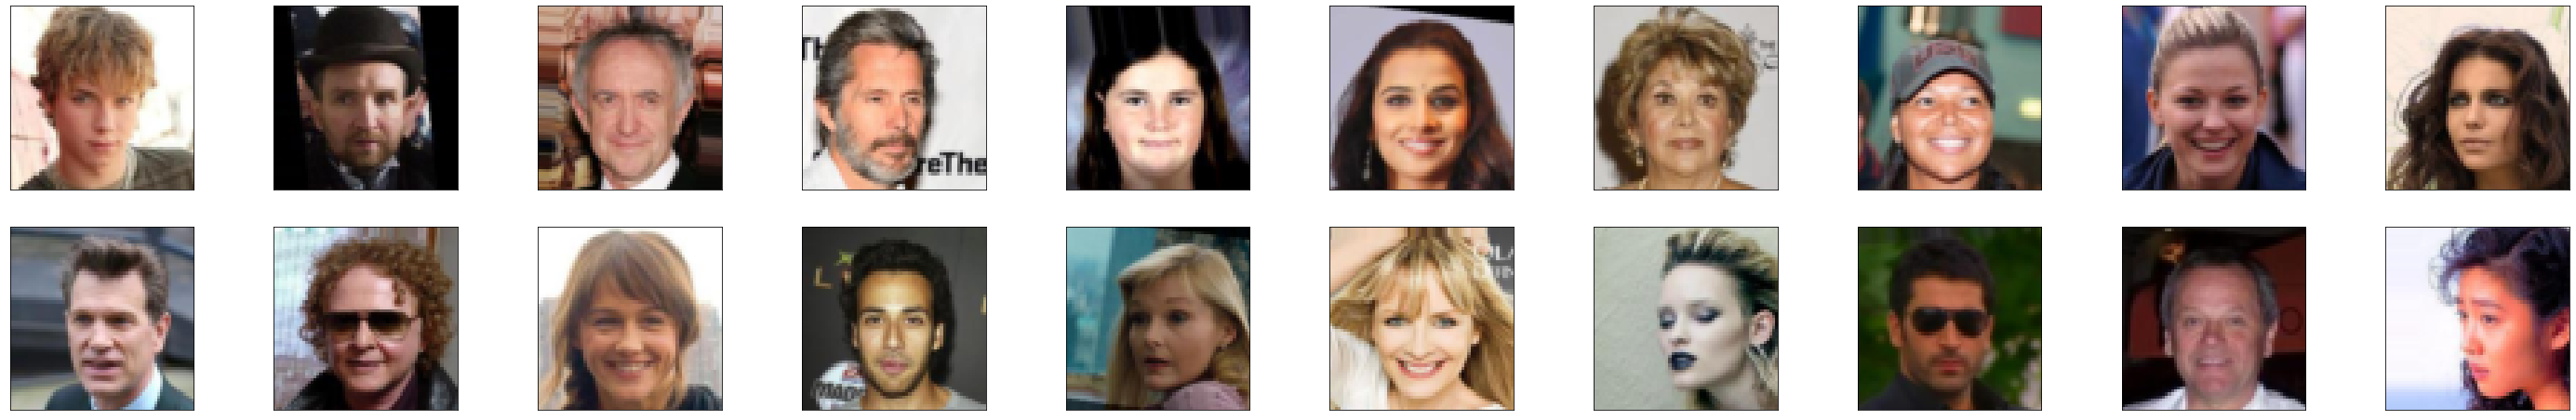

In [16]:
# visualizing few images from dataset

import numpy as np
# helper function to un-normalize and display an image
def imshow(img):
  img = img.numpy().transpose((1, 2, 0))
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt.imshow(img)   # convert from tensor image

dataiter = iter(data_loader)
images,labels = dataiter.next()

# plot the images in batch along with the corresponding labels
fig = plt.figure(figsize=(50,8))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
  imshow(images[idx])

In [20]:
# Creating Generator Architecture
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        # 1st layer
        nn.ConvTranspose2d(in_channels = Z_DIM, out_channels = G_HIDDEN*8, kernel_size = 4, stride = 1, padding = 0, bias=False),
        nn.BatchNorm2d(G_HIDDEN*8),
        nn.ReLU(inplace=True),
        # 2nd layer
        nn.ConvTranspose2d(in_channels = G_HIDDEN*8, out_channels= G_HIDDEN*4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(G_HIDDEN*4),
        nn.ReLU(inplace=True),
        # 3rd layer
        nn.ConvTranspose2d(in_channels=G_HIDDEN*4, out_channels=G_HIDDEN*2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(G_HIDDEN*2),
        nn.ReLU(inplace=True),
        # 4th layer
        nn.ConvTranspose2d(in_channels=G_HIDDEN*2, out_channels=G_HIDDEN, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(G_HIDDEN),
        nn.ReLU(inplace=True),
        # output layer
        nn.ConvTranspose2d(in_channels=G_HIDDEN, out_channels=IMAGE_CHANNEL, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )
  
  def forward(self,x):
    return self.main(x)

In [21]:
# testing generator architecture
x = torch.randn(128, 100, 1, 1)
model = Generator()
print (model(x).shape)      # (128x100x1x1) -> (128x3x64x64)

torch.Size([128, 3, 64, 64])


In [22]:
# Creating Disciminator Architecture
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        # 1st layer
        nn.Conv2d(in_channels=IMAGE_CHANNEL, out_channels=D_HIDDEN, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # 2nd layer
        nn.Conv2d(in_channels=D_HIDDEN, out_channels=D_HIDDEN*2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(D_HIDDEN*2),
        nn.LeakyReLU(0.2, inplace=True),
        # 3rd layer
        nn.Conv2d(in_channels=D_HIDDEN*2, out_channels=D_HIDDEN*4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(D_HIDDEN*4),
        nn.LeakyReLU(0.2, inplace=True),
        # 4th layer
        nn.Conv2d(in_channels=D_HIDDEN*4, out_channels=D_HIDDEN*8, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(D_HIDDEN*8),
        nn.LeakyReLU(0.2, inplace=True),
        # output layer
        nn.Conv2d(in_channels=D_HIDDEN*8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
        nn.Sigmoid()
    )
  
  def forward(self,x):
    return self.main(x).view(-1, 1).squeeze(1)

In [23]:
# testing discriminator architecture
x = torch.randn(128,3,64,64)
model = Discriminator()
print (model(x).shape)

torch.Size([128])


In [24]:
# creating Generator object
netG = Generator()
netG.to(device)
print (netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [25]:
# creaing Discriminator object
netD = Discriminator()
netD.to(device)
print (netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [27]:
# defining loss and optimizer
criterion = nn.BCELoss()

optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))

## Training iteration

### Training procedure includes - 
1. Train the discriminator with the real data and recognize it as real data.
2. Train the discriminator with the fake data and recognize it as fake data.
3. Train the generator with the fake data and recognize it as real.

- The first two steps let the discriminator learn how to tell the difference between real data and fake data.
- The third step teaches the generator how to confuse the discriminator with generated samples.



In [30]:
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)
viz_noise.shape

torch.Size([128, 100, 1, 1])

In [34]:
# Training both the networks
for epoch in range(1,EPOCHS+1):
  for idx, (images, _) in enumerate(data_loader):
    x_real = images.to(device)
    real_label = torch.full((x_real.size(0), ), REAL_LABEL, device=device)
    fake_label = torch.full((x_real.size(0), ), FAKE_LABEL, device=device)

    # update D with real data
    netD.zero_grad()
    y_real = netD(x_real)
    loss_D_real = criterion(y_real, real_label)
    loss_D_real.backward()

    # update D with fake data
    z_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)
    x_fake = netG(z_noise)
    y_fake = netD(x_fake.detach())
    loss_D_fake = criterion(y_fake, fake_label)
    loss_D_fake.backward()
    optimizerD.step()

    # update G with fake data
    netG.zero_grad()
    y_fake_r = netD(x_fake)
    loss_G = criterion(y_fake_r, real_label)
    loss_G.backward()
    optimizerG.step()

    if idx%100 == 0:
      print (f'Epoch: {epoch}/{EPOCHS} [{idx}/{len(data_loader)}] loss_D_real: {loss_D_real.mean().item():.4f} loss_D_fake: {loss_D_fake.mean().item():.4f} loss_G: {loss_G.mean().item():.4f}')
      with torch.no_grad():
        viz_sample = netG(viz_noise)
        vutils.save_image(viz_sample, os.path.join(OUT_PATH, f'fake_face_samples{epoch}.png'), normalize=True)
  torch.save(netG.state_dict(), os.path.join(OUT_PATH, f'netG_{epoch}'))
  torch.save(netD.state_dict(), os.path.join(OUT_PATH, f'netD_{epoch}'))

Epoch: 1/25 [0/199] loss_D_real: 0.0842 loss_D_fake: 1.2681 loss_G: 8.4492
Epoch: 1/25 [100/199] loss_D_real: 0.3441 loss_D_fake: 0.2369 loss_G: 2.6390
Epoch: 2/25 [0/199] loss_D_real: 0.3150 loss_D_fake: 0.6199 loss_G: 3.3687
Epoch: 2/25 [100/199] loss_D_real: 0.4398 loss_D_fake: 0.3851 loss_G: 2.8735
Epoch: 3/25 [0/199] loss_D_real: 0.5953 loss_D_fake: 0.1811 loss_G: 2.0492
Epoch: 3/25 [100/199] loss_D_real: 0.1503 loss_D_fake: 0.8919 loss_G: 4.0301
Epoch: 4/25 [0/199] loss_D_real: 0.6238 loss_D_fake: 0.4685 loss_G: 2.5605
Epoch: 4/25 [100/199] loss_D_real: 0.3768 loss_D_fake: 0.3013 loss_G: 3.0950
Epoch: 5/25 [0/199] loss_D_real: 0.2316 loss_D_fake: 0.7881 loss_G: 4.6605
Epoch: 5/25 [100/199] loss_D_real: 0.1608 loss_D_fake: 0.4704 loss_G: 4.3980
Epoch: 6/25 [0/199] loss_D_real: 0.6520 loss_D_fake: 0.2395 loss_G: 2.0833
Epoch: 6/25 [100/199] loss_D_real: 0.1675 loss_D_fake: 0.8934 loss_G: 4.6214
Epoch: 7/25 [0/199] loss_D_real: 0.1465 loss_D_fake: 0.2618 loss_G: 2.9763
Epoch: 7/25 [

# Generated Faces

After epoch 1 - 
 - ![fake_face_samples1](https://user-images.githubusercontent.com/26361028/91946642-f431e800-ed1c-11ea-9316-5681a8441a63.png)

After epoch 25 -
 - ![fake_face_samples25](https://user-images.githubusercontent.com/26361028/91946810-014ed700-ed1d-11ea-9e0d-0750c3998d9e.png)

